**Predicting the Current Rank of Professional Singles Male Tennis Players**


**Introduction:**
It was commonly believed that players’ physical strength would deteriorate over years. However, recent research shows that the mean age of top 100 men tennis players has increased significantly compared to the last decades (Gallo-Salazar et al. 873). Contrary to popular belief, some current players such as Novak Djokovic, Rafael Nadal, and Roger Federer are able to win major tournaments such as Grand Slams after they reach 30, a relatively senior age for professional tennis players. 
This project uses the player_stat dataset to predict the current rank of professional singles male tennis players by age and experience, thus answering the research question: How do age and seasons played affect players’ current rank? 
The hypothesis is that players would obtain higher ranks as they age and play in more seasons. It is predicted that experience would outweigh the disadvantages brought by aging due to improving training methods and medical technology. Circumstances such as illness and injury that might halt players’ careers are not taken into account in this project. 

The player_stat dataset contains information on singles male tennis players ranked in the top 500 in the ATP scoring system from 2020. The performance of professional male tennis players is accessed objectively by the Association of Tennis Professionals (ATP) ranking system.Players gain points according to their round of exit and the scale of the tournament. 

Typically, points are valid for 52 weeks. The columns which are used in the analysis are defined below:
Age; 
Current rank: refers to ATP rank;
Seasons played: a season is defined as a calendar year in professional tennis.





**Preliminary exploratory data analysis:**

First we load the necessary libraries for our analysis and set a seed so our results are reproducible.



In [1]:
#Load libraries here
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(repr)
library(dplyr)
library(GGally)
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Loading the data set we intend to investigate.

In [2]:
#Read data
tennis_data_raw <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)

See spec(...) for full column specifications.



There are many columns in the data set. To narrow down potential predictors we removed columns for any of the following reasons: 

-We are not interested in specific dates for our analysis.

-Mostly NA values.

-We want to predict a players Current Rank, which is a regression problem. For simplicity we removed non-numeric columns.


In [15]:
#Tidying data
names(tennis_data_raw) <- make.names(names(tennis_data_raw), unique = TRUE)
tennis_data_tidy <- tennis_data_raw %>% 
mutate(Last_Appearance = Last.Appearance) %>%
select(-Wikipedia, -X1) %>%
#Separating values
separate(col = Age, into = c("Age", "Birthdate"), sep = " ") %>%
separate(col = Current.Rank, into = c("Current_Rank", "Points_at_Current_Rank"), sep = " ") %>% 
separate(col = Best.Rank, into = c("Best_Rank", "Best_Rank_Date"), sep = " ") %>%
separate(col = Current.Elo.Rank, into = c("Current_Elo_Rank", "Current_Elo_Score"), sep = " ") %>% 
separate(col = Best.Elo.Rank, into = c("Best_Elo_Rank", "Best_Elo_Rank_Date"), sep = " ") %>% 
separate(col = Peak.Elo.Rating, into = c("Peak_Elo_Rating", "Peak_Elo_Rating_Date"), sep = " ") %>% 
separate(col = GOAT.Rank, into = c("GOAT_Rank", "GOAT_Points"), sep = " ") %>%
lapply( function(x) gsub(pattern = "[\\(\\)]",replacement = "", as.character(x))) %>%
data.frame() %>%
#Converting Date format
separate(col = Birthdate, into = c("Birthday","Birthmonth", "Birthyear"), sep = "-") %>% 
separate(col = Best_Rank_Date, into = c("Best_Rank_Day", "Best_Rank_Month", "Best_Rank_Year"), sep = "-") %>%
separate(col = Peak_Elo_Rating_Date, into = c("Peak_Elo_Rating_Day", "Peak_Elo_Rating_Month" ,"Peak_Elo_Rating_Year"), sep = "-") %>%
separate(col = Best_Elo_Rank_Date, into = c("Best_Elo_Rank_Day", "Best_Elo_Rank_Month" ,"Best_Elo_Rank_Year"), sep = "-") %>%
separate(col = Last_Appearance, into = c("Last_Appearance_Day", "Last_Appearance_Month" ,"Last_Appearance_Year"), sep = "-") %>%
#Converting to int
mutate_at(c("Age", "Birthday", "Birthmonth", "Birthyear", "Current_Rank", "Points_at_Current_Rank", "Current_Elo_Rank", "Best_Rank", "Best_Rank_Day", "Current_Elo_Score",
            "Best_Rank_Year", "Peak_Elo_Rating_Day", "Peak_Elo_Rating_Month", "Peak_Elo_Rating_Year", "Peak_Elo_Rating", "Best.Season", "Retired",
            "Best_Elo_Rank", "Best_Elo_Rank_Day", "Best_Elo_Rank_Month" ,"Best_Elo_Rank_Year","Last_Appearance_Day", "Last_Appearance_Month" ,"Last_Appearance_Year", 
            "GOAT_Rank", "GOAT_Points", "Grand.Slams", "Davis.Cups", "Olympics", "Team.Cups", "Turned.Pro", "Seasons", "Titles" ), as.integer) %>%
mutate(Age_at_Best_Rank = Best_Rank_Year - Birthyear)
       
tennis_data_tidy$Retired[tennis_data_tidy$Retired > 1990] <- "yes"
tennis_data_tidy$Retired[is.na(tennis_data_tidy$Retired)] <- "no"
       
#Removed many vectors for easier viewing of table and narrowing search
tennis_data_filtered <- tennis_data_tidy %>%  
                   #Removed columns with mostly NA 
                   select(-Davis.Cups, -Team.Cups, -Olympics, -Weight, -Grand.Slams, -Tour.Finals,-Masters, -Weeks.at.No..1, 
                           -Height, -Prize.Money, -Last.Appearance, -Titles, -Active) %>%       
                   #Removed days, months and years
                   select(-Birthday, -Birthmonth, -Birthyear, -Best_Rank_Day, -Best_Rank_Month, -Best_Rank_Year,
                          -Peak_Elo_Rating_Day, -Peak_Elo_Rating_Month, -Peak_Elo_Rating_Year,
                          -Best_Elo_Rank_Day, -Best_Elo_Rank_Month, - Best_Elo_Rank_Year, - Last_Appearance_Day, -Last_Appearance_Month,-Last_Appearance_Year, -Best.Season) %>% 
                   #Removed non-numeric columns
                   select(-Country, -Plays, -Favorite.Surface, -Name, -Turned.Pro, -Retired, -Backhand, -Facebook, - Twitter, - Nicknames, 
                          -Coach, -Web.Site, -Residence, -Birthplace)%>%
                   arrange(Current_Rank)
           
 head(tennis_data_filtered, 10)

,Age,Current_Rank,Points_at_Current_Rank,Best_Rank,Seasons,Current_Elo_Rank,Current_Elo_Score,Best_Elo_Rank,Peak_Elo_Rating,GOAT_Rank,GOAT_Points,Age_at_Best_Rank
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,33,1,10235,1,19,1,2406,1,2552,3,805,22
2,32,2,9720,1,17,2,2390,1,2629,2,819,24
3,38,3,6590,1,22,3,2328,1,2550,1,929,23
4,23,4,5960,4,5,5,2204,4,2243,109,27,23
5,26,5,5890,4,10,6,2188,5,2211,58,58,24
6,21,6,5375,5,4,8,2160,8,2175,139,21,21
7,22,7,3345,3,8,13,2096,5,2231,65,54,20
8,23,8,2870,8,3,17,2075,13,2102,245,7,23
9,31,9,2630,9,11,16,2080,9,2135,151,18,31


                                                              Figure 1:Possible Predictors

Splitting the data with an arbitrarily chosen proportion of 75%.

In [16]:
tennis_clean <- filter(tennis_data_filtered, Current_Rank != is.na(Current_Rank))
tennis_split <- initial_split(tennis_clean, prop = 0.75, strata = Current_Rank)
tennis_training_exploratory <- training(tennis_split)
tennis_testing_exploratory <- testing(tennis_split)

We investigate the top 10 players in the training set. There are three types of players in the table:

-Achieved their best rank in their late twenties to early thirties.

-Achieved their best rank in their early twenties but still very close to their best rank in their thirties.

-Recently achieved their best rank in their early twenties.

Half the players in the top 10 from the training set are older. This is an indication that there may be a new trend of older players at the highest level as Gallo-Salazar et al claimed.  

In [17]:
tennis_table <- tennis_training_exploratory %>%
                     arrange(Current_Rank) %>%
                     head(10) %>%
                     select(Age, Current_Rank, Age_at_Best_Rank, Best_Rank)
tennis_table

,Age,Current_Rank,Age_at_Best_Rank,Best_Rank
,<int>,<int>,<int>,<int>
1,32,2,24,1
2,38,3,23,1
3,23,4,23,4
4,26,5,24,4
5,21,6,21,5
6,23,8,23,8
7,31,9,31,9
8,33,10,30,6
9,29,11,27,7


    Figure 2:Exploratory Table of ATP Ranks

There is no clear relationship between Age and Current Rank, however through closer inspection there may be meaningful data. There appears to be equally if not more players aged 28 or older compared to those younger than 28 in the top 100. This potential pattern extends to the higher rankings (numerically). Most players that are ranked 250 or higher (numerically) tend to be younger. This is more evidence that age may be effective in predicting a players rank.

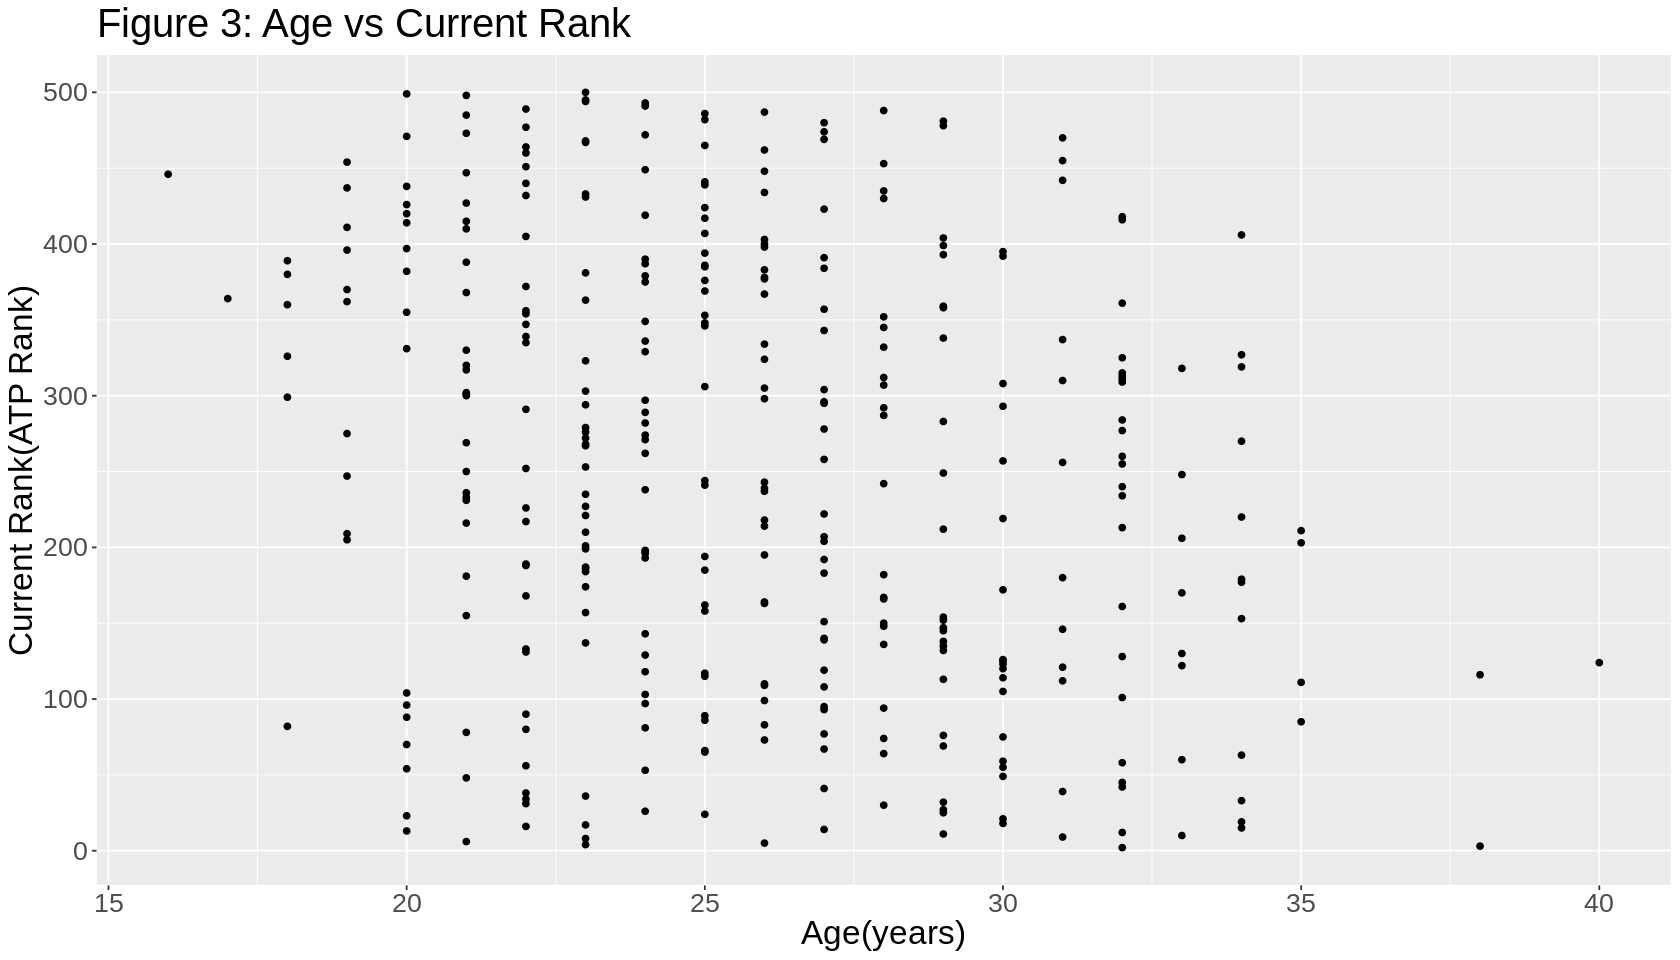

In [27]:
#Relevant Plot
options(repr.plot.width = 14, repr.plot.height = 8)

age_current_rank <- tennis_training_exploratory %>%
                    ggplot(aes(x = Age, y= Current_Rank)) +
                    geom_point() +
                    labs(x = "Age(years)", y = "Current Rank(ATP Rank)") +
                    theme(text = element_text(size =20)) +
                    ggtitle("Figure 3: Age vs Current Rank")
age_current_rank

Figure 4 shows a stronger negative relationship with less noise in comparison to Figure 3. Seasons is possibly a good predictor for our data analysis.

Warning message:
“Removed 95 rows containing missing values (geom_point).”


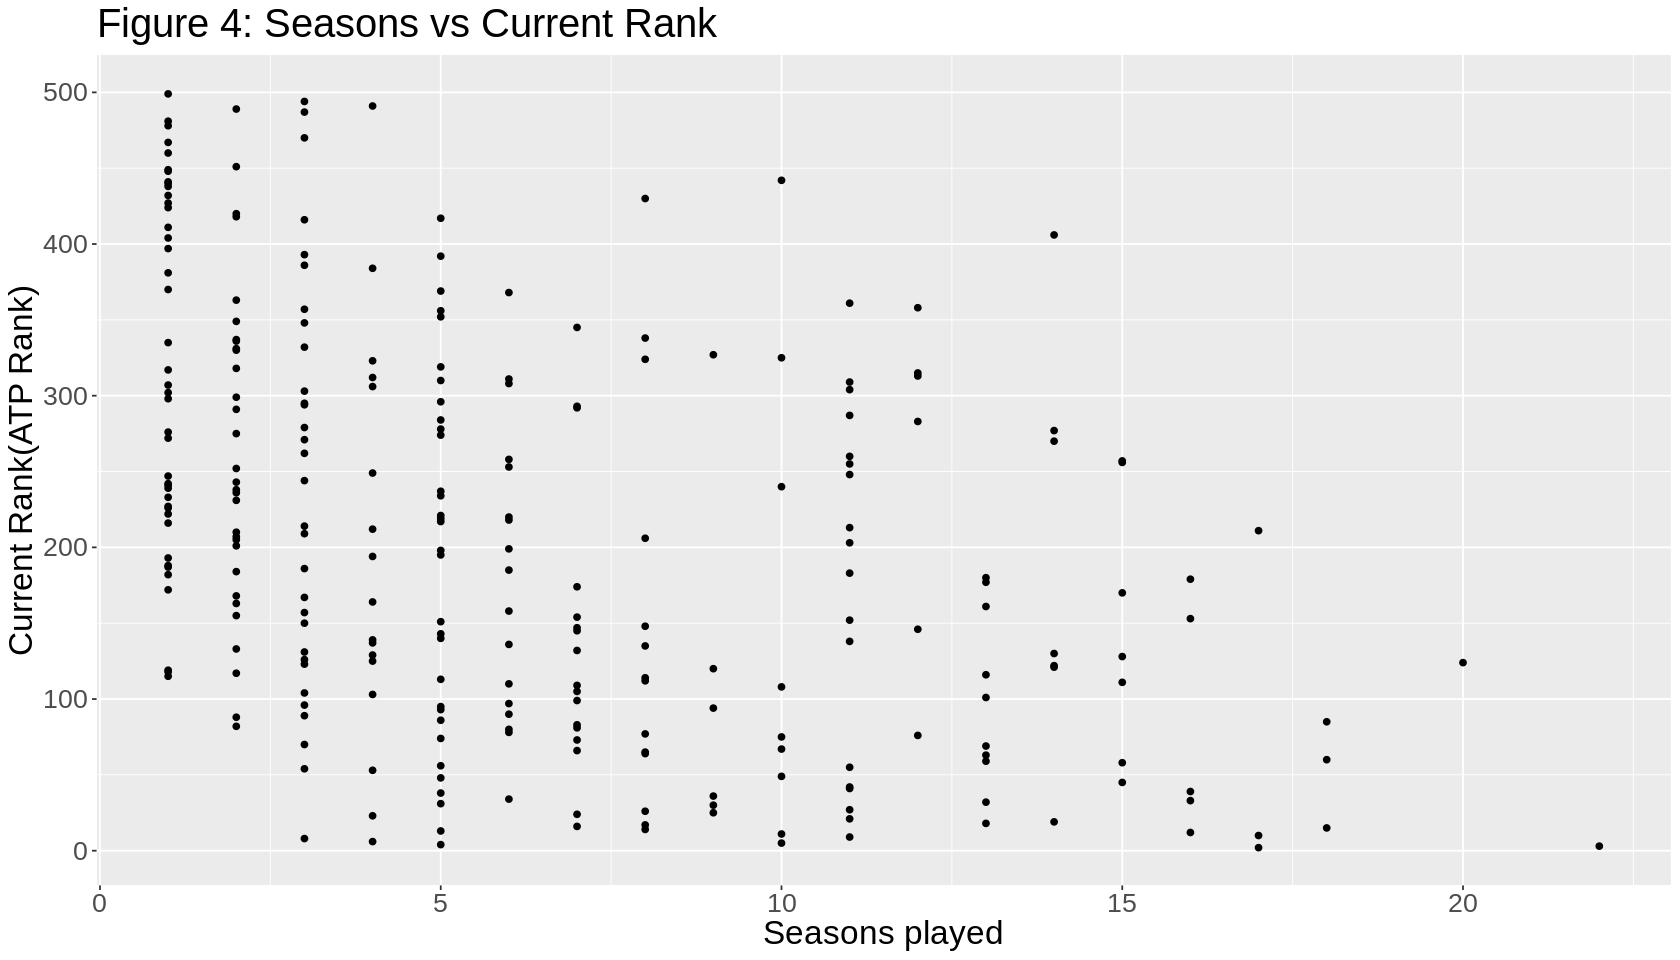

In [28]:
#Relevant Plot
options(repr.plot.width = 14, repr.plot.height = 8)

season_current_rank <- tennis_training_exploratory %>%
                    ggplot(aes(x = Seasons, y= Current_Rank)) +
                    geom_point() +
                    labs(x = "Seasons played", y = "Current Rank(ATP Rank)") +
                    theme(text = element_text(size =20)) +
                    ggtitle("Figure 4: Seasons vs Current Rank")
season_current_rank

Based on Figure 2,3, and 4 we will use Age and Seasons as predictors. Using ggpairs we can check the correlation with potential predictors with Current Rank.                                    

geom_point: na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

geom_point: na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 95 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 237 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 237 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 95 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 237 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 237 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 95 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pear

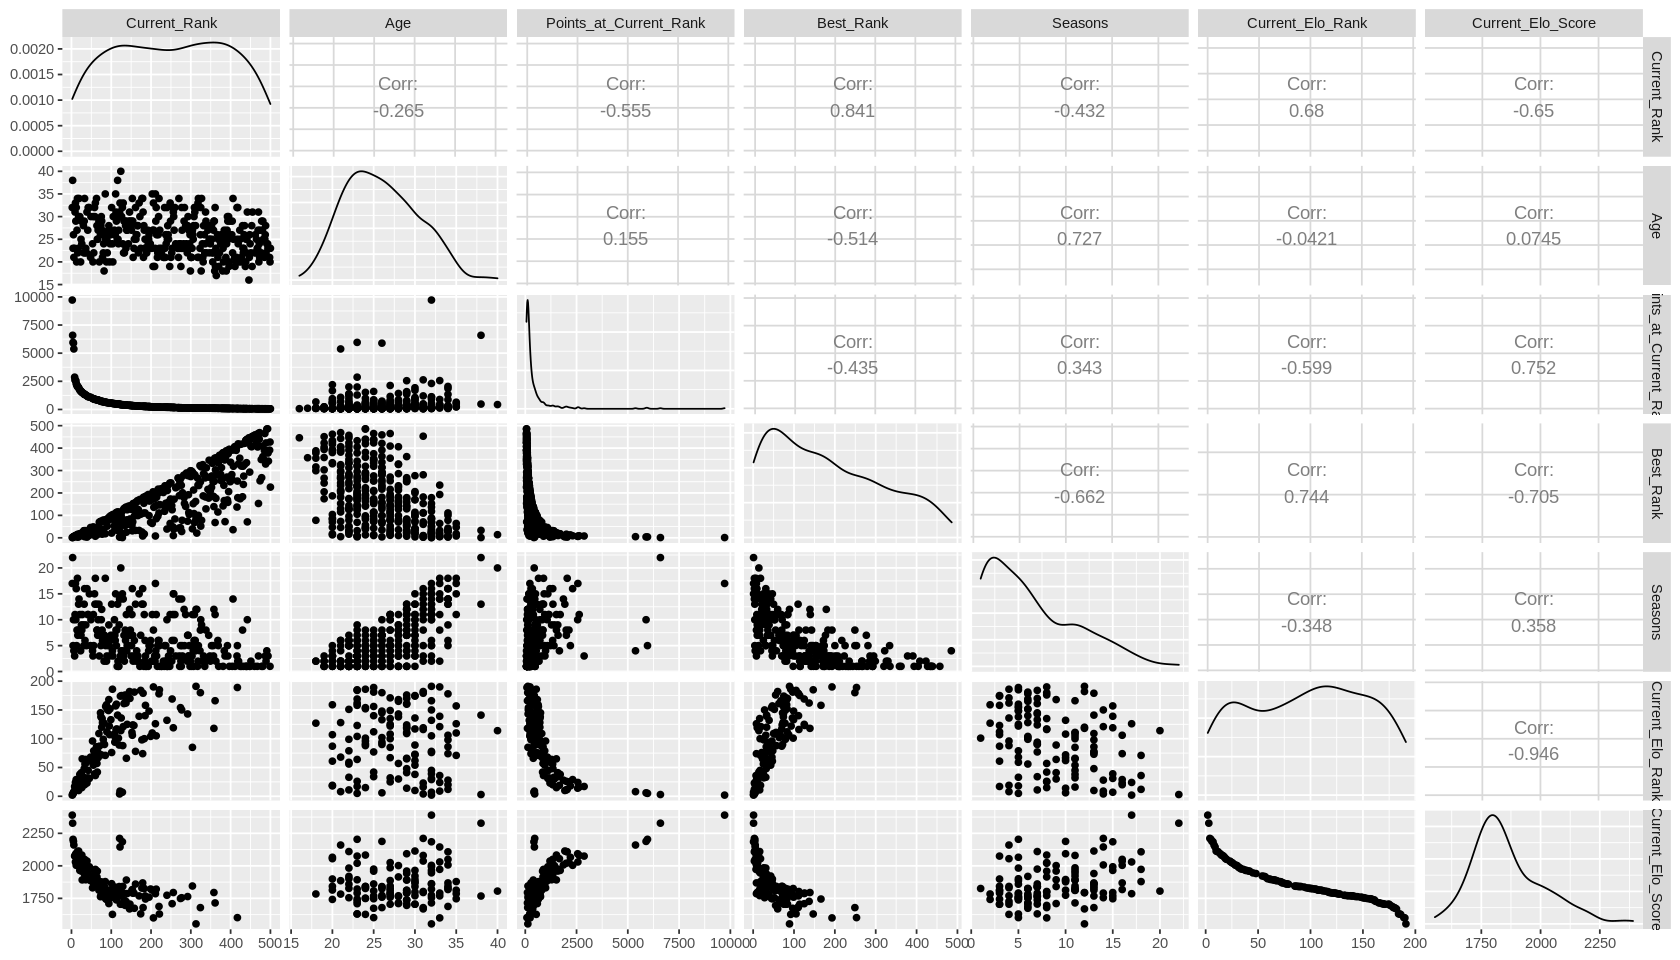

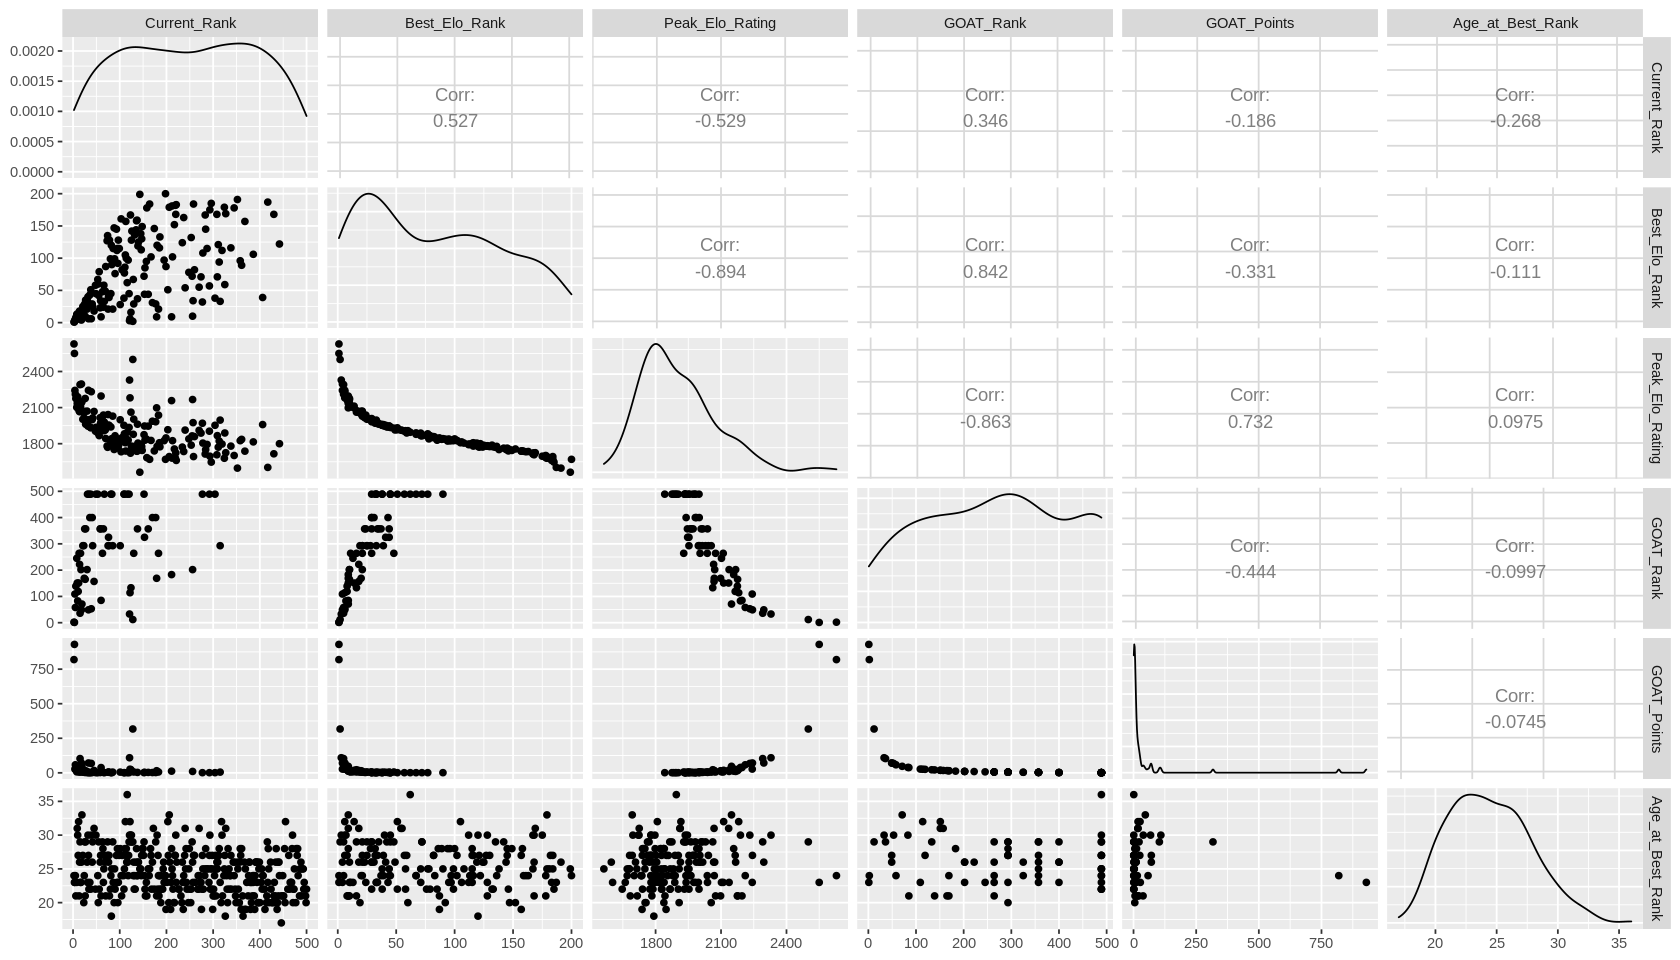

In [25]:
tennis_pairs_1 <- tennis_training_exploratory %>%
                  select(2,1, 3:7)

tennis_pairs_2 <- tennis_training_exploratory %>%
                  select(2, 8:12)

tennis_eda_1 <- tennis_pairs_1 %>%
                ggpairs() 
                geom_point()

tennis_eda_2 <- tennis_pairs_2 %>%
                ggpairs() 
                geom_point()
tennis_eda_1
tennis_eda_2

                                  Figure 4: Predictor correlation with Current Rank

Consider figure 4 as both plots above split into two seperate plots for easier viewing.

From the warning above some of the predictors have many NA values. Using glance we can check the predictors with strong correlation to make sure we have complete observations with Current Rank, Age, and Seasons. 

In [29]:
tennis_obs_1 <- tennis_training_exploratory %>%
                select(Age,Current_Rank, Seasons, Points_at_Current_Rank)
glance(tennis_obs_1)

Warning message:
“Data frame tidiers are deprecated and will be removed in an upcoming release of broom.”


nrow,ncol,complete.obs,na.fraction
<int>,<int>,<int>,<dbl>
372,4,277,0.06384409


Figure 5.1: Points at Current Rank Observations 

In [30]:
tennis_obs_2 <- tennis_training_exploratory %>%
                select(Age,Current_Rank, Seasons, Best_Rank)
glance(tennis_obs_2)


Warning message:
“Data frame tidiers are deprecated and will be removed in an upcoming release of broom.”


nrow,ncol,complete.obs,na.fraction
<int>,<int>,<int>,<dbl>
372,4,277,0.06384409


Figure 5.2: Best Rank Observations

In [31]:
tennis_obs_3 <- tennis_training_exploratory %>%
                select(Age,Current_Rank, Seasons, Best_Elo_Rank)
glance(tennis_obs_3)

Warning message:
“Data frame tidiers are deprecated and will be removed in an upcoming release of broom.”


nrow,ncol,complete.obs,na.fraction
<int>,<int>,<int>,<dbl>
372,4,174,0.1969086


Figure 5.3: Best Elo Rank Observations 

In [32]:
tennis_obs_4 <- tennis_training_exploratory %>%
                select(Age,Current_Rank, Seasons, Current_Elo_Score)
glance(tennis_obs_4)

Warning message:
“Data frame tidiers are deprecated and will be removed in an upcoming release of broom.”


nrow,ncol,complete.obs,na.fraction
<int>,<int>,<int>,<dbl>
372,4,135,0.2231183


Figure 5.4: Current Elo Score Observations

In [33]:
tennis_obs_5 <- tennis_training_exploratory %>%
                select(Age,Current_Rank, Seasons, Current_Elo_Rank)
glance(tennis_obs_5)


Warning message:
“Data frame tidiers are deprecated and will be removed in an upcoming release of broom.”


nrow,ncol,complete.obs,na.fraction
<int>,<int>,<int>,<dbl>
372,4,135,0.2231183


Figure 5.5: Current Elo Rank Observations

In [34]:
tennis_obs_6 <- tennis_training_exploratory %>%
                select(Age,Current_Rank, Seasons, Best_Elo_Rank)
glance(tennis_obs_6)

Warning message:
“Data frame tidiers are deprecated and will be removed in an upcoming release of broom.”


nrow,ncol,complete.obs,na.fraction
<int>,<int>,<int>,<dbl>
372,4,174,0.1969086


Figure 5.6: Best Elo Rank Observations

In [35]:
tennis_obs_7 <- tennis_training_exploratory %>%
                select(Age,Current_Rank, Seasons, Peak_Elo_Rating)
glance(tennis_obs_7)

Warning message:
“Data frame tidiers are deprecated and will be removed in an upcoming release of broom.”


nrow,ncol,complete.obs,na.fraction
<int>,<int>,<int>,<dbl>
372,4,174,0.1969086


Figure 5.7:Peak Elo Rating Observations

**Methods**

Before starting the data analysis we need to make sure all observations are complete to avoid errors.

In [45]:
tennis_training <- tennis_training_exploratory %>%
                         filter(Age != is.na(Age)) %>%
                         filter(Seasons != is.na(Seasons)) %>%
                         filter(Points_at_Current_Rank != is.na(Points_at_Current_Rank)) 

tennis_testing <- tennis_testing_exploratory %>%
                         filter(Age != is.na(Age)) %>%
                         filter(Seasons != is.na(Seasons)) %>%
                         filter(Points_at_Current_Rank != is.na(Points_at_Current_Rank)) 

From Figure 4, most of the predictors' relationship with Current Rank is not linear, therefore we will use knn regression. First we need to perform cross validation to find the best k value.

In [46]:
tennis_recipe <- recipe(Current_Rank ~Seasons + Age, data = tennis_training) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())

tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("regression")

tennis_vfold <- vfold_cv(tennis_training, v = 10, strata = Current_Rank)

tennis_wkflw <- workflow() %>%
add_recipe(tennis_recipe) %>%
add_model(tennis_spec)

In [47]:
gridvals <- tibble(neighbors = seq(from = 1,to =  200, by= 2)) 

tennis_results <- tennis_wkflw %>%
                  tune_grid(resamples = tennis_vfold, grid = gridvals) %>%
                  collect_metrics() 

In [48]:
tennis_min <- tennis_results %>%
              filter(.metric == "rmse") %>%
              filter(mean == min(mean))
tennis_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,rmse,standard,62.24228,10,3.639237,Model004


                    Figure 6: Best K

Now we use the optimal amount of neighbors for our model.

In [49]:
kmin <- tennis_min %>% pull(neighbors)

tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
  set_engine("kknn") %>%
  set_mode("regression")

tennis_fit <- workflow() %>%
  add_recipe(tennis_recipe) %>%
  add_model(tennis_spec) %>%
  fit(data = tennis_training)

We find the mean estimate of for predicting the testing set is 119.9622

In [50]:
tennis_summary <- tennis_fit %>%
  predict(tennis_testing) %>%
  bind_cols(tennis_testing) %>%
  metrics(truth = Current_Rank, estimate = .pred) %>%
  filter(.metric == "rmse")

tennis_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,78.53179


Figure 7: Model Accuracy

Making prediction lines for final visualization.

In [54]:
tennis_preds <- tibble(Age = seq(from = 1, to = 40, by = 1), Seasons = seq(from = 1, to = 40, by = 1))
tennis_preds <- tennis_fit %>%
  predict(tennis_preds) %>%
  bind_cols(tennis_preds)

Warning message:
“Removed 10477 row(s) containing missing values (geom_path).”
Warning message:
“Removed 10476 row(s) containing missing values (geom_path).”


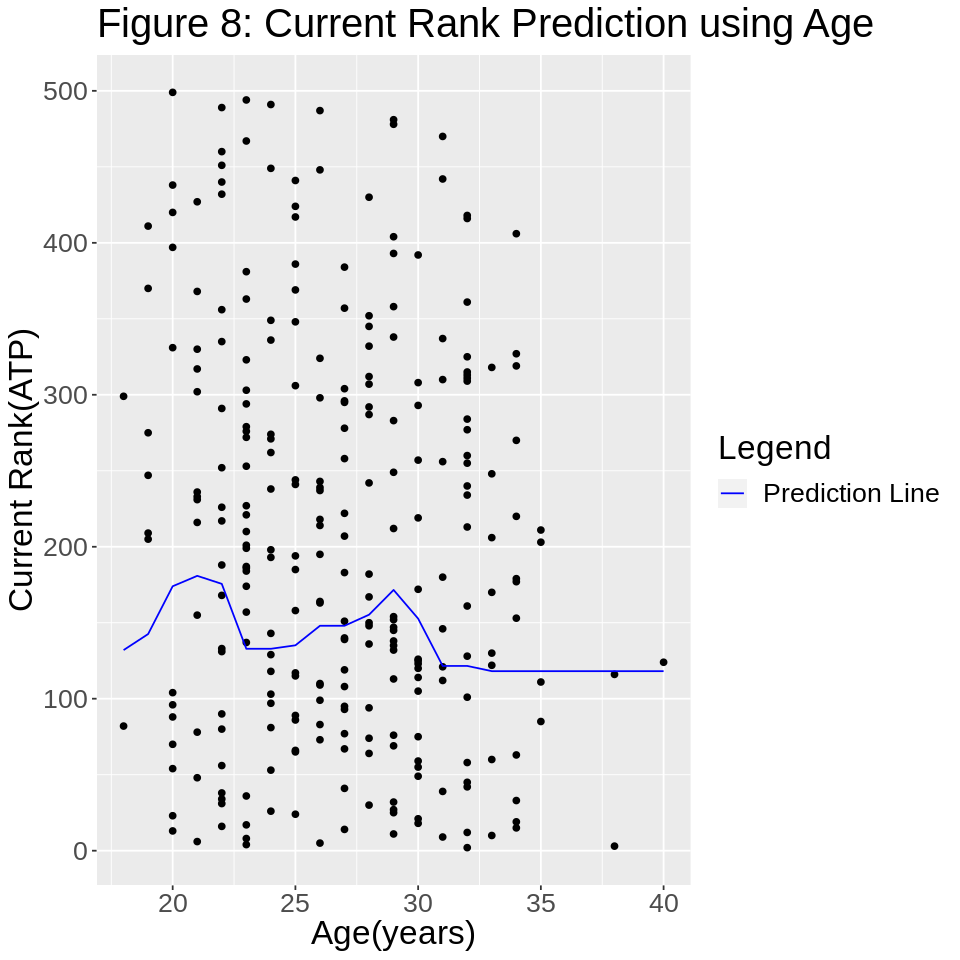

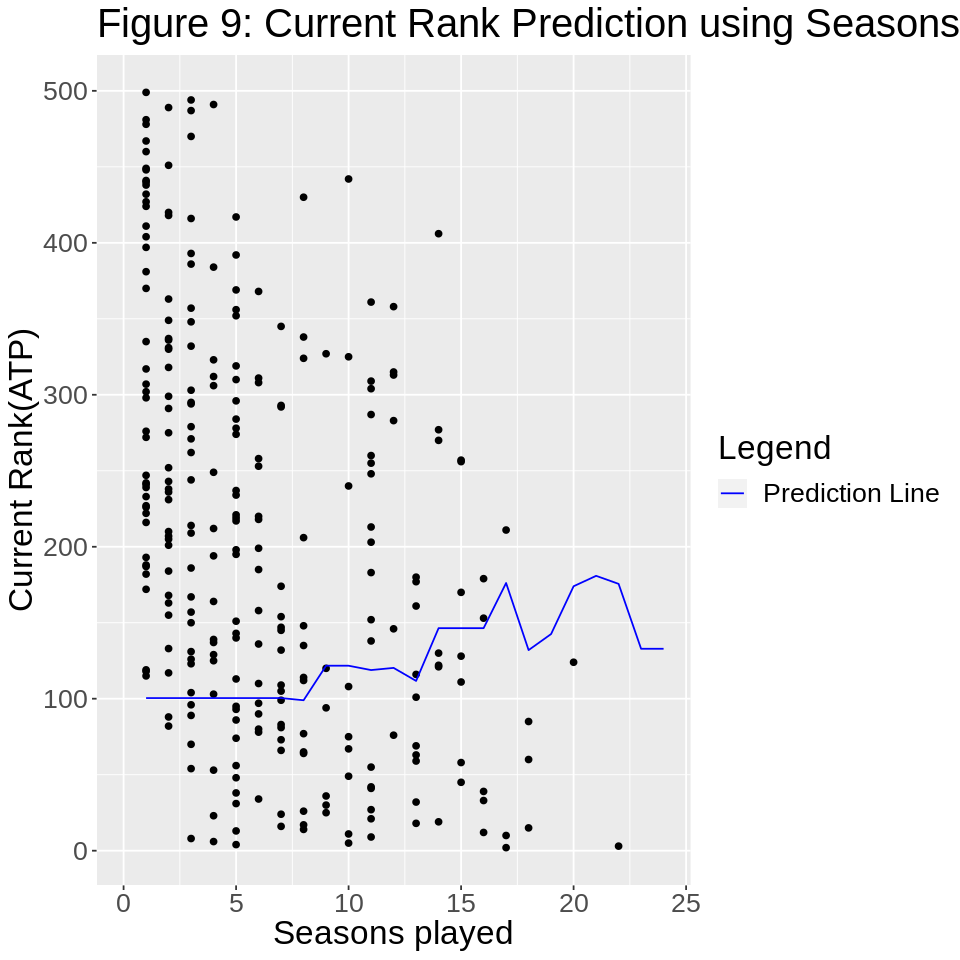

In [71]:
options(repr.plot.width = 8, repr.plot.length = 1)

plot_Age <- ggplot(tennis_training, aes(x = Age, y = Current_Rank)) +
              geom_point() +
              geom_line(data = tennis_preds, 
                    mapping = aes(x = Age, y = .pred, color = "Prediction Line")) +
              scale_color_manual(name = "Legend", values = c("Prediction Line" = "blue")) +
              theme(text = element_text(size=20)) +
              xlab("Age(years)") +
              ylab("Current Rank(ATP)") +
              xlim(c(18, 40)) +
              ggtitle("Figure 8: Current Rank Prediction using Age")
plot_Age
plot_Seasons <- ggplot(tennis_training, aes(x = Seasons, y = Current_Rank)) +
                  geom_point() +
                  geom_line(data = tennis_preds, 
                  mapping = aes(x = Seasons, y = .pred, color = "Prediction Line")) +
                  scale_color_manual(name = "Legend", values = c("Prediction Line" = "blue")) +
                  theme(text = element_text(size=20)) +
                  xlab("Seasons played") +
                  ylab("Current Rank(ATP)") + 
                  xlim(c(0, 24)) +
                  ggtitle("Figure 9: Current Rank Prediction using Seasons")
plot_Seasons
